In [1]:
import pandas as pd
import numpy as np

# 한글 폰트 깨짐 방지
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

#에러 무시
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import scale, minmax_scale, robust_scale, StandardScaler

import xgboost as xgb

import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
hts = pd.read_csv('0909_hts.csv', encoding = 'CP949')

In [3]:
# 안타 여부 표시
hts['안타여부'] = 0
hts['장타여부'] = 0

# 안타가 된 타구만 1로 
hts['안타여부'][(hts['타격결과'] == '1루타')] = 1
hts['안타여부'][(hts['타격결과'] == '2루타')] = 1
hts['안타여부'][(hts['타격결과'] == '3루타')] = 1
hts['안타여부'][(hts['타격결과'] == '홈런')] = 1
# hts['안타여부'][(hts['타격결과'] == '직선타')] = 1 # 직선타를 안타로 설정

# 장타가 된 타구
hts['장타여부'][(hts['타격결과'] == '1루타')] = 1
hts['장타여부'][(hts['타격결과'] == '내야안타(1루타)')] = 1
hts['장타여부'][(hts['타격결과'] == '2루타')] = 2
hts['장타여부'][(hts['타격결과'] == '3루타')] = 3
hts['장타여부'][(hts['타격결과'] == '홈런')] = 4

In [4]:
hts = hts.reset_index(drop = True)

In [5]:
# 안타가 된 타구만 추출
hts_hit = hts.loc[(hts['안타여부'] == 1)]

# 안타가 되지 않은 타구 추출
hts_nonhit = hts.loc[(hts['안타여부'] == 0)]

In [6]:
hts_hit_except_single = hts_hit.loc[(hts_hit['타격결과'] == '2루타') |
           (hts_hit['타격결과'] == '3루타')|
           (hts_hit['타격결과'] == '직선타')|                         
           (hts_hit['타격결과'] == '홈런')]

In [7]:
hts_hit_except_single['발사각도'].mean()

21.02284237726097

In [8]:
hts.to_csv('0909_타격결과col.csv',encoding = 'cp949', index = False)

In [9]:
hts_pasaeng = pd.read_csv('0909_타격결과col.csv',encoding = 'cp949')

In [10]:
#                              100 - |21.022~(최적의 각도) -          x            |
hts_pasaeng['파생_발사각도'] = 100 - abs(21.02284237726097 - hts_pasaeng['발사각도'])

In [11]:
hts_pasaeng.groupby('타격결과')['파생_발사각도'].agg('mean').sort_values()

타격결과
파울플라이        54.439143
인필드플라이       56.309971
삼중살타         65.327158
야수선택         70.783824
땅볼아웃         71.536644
병살타          71.926959
내야안타(1루타)    73.927803
플라이          81.359380
1루타          85.191359
희생플라이        87.848240
직선타          88.269917
2루타          91.686495
홈런           92.046679
3루타          92.231953
Name: 파생_발사각도, dtype: float64

In [12]:
df_num = hts_pasaeng[['타구속도', '파생_발사각도']]

In [13]:
# minmax
df_scale_minmax = minmax_scale(df_num)
df_scale_minmax = pd.DataFrame(df_scale_minmax, columns = df_num.columns)
df_scale_minmax

,타구속도,파생_발사각도
0,0.488539,0.695866
1,0.523687,0.844101
2,0.688252,0.734551
3,0.318720,0.894663
4,0.778892,0.754213
...,...,...
117682,0.581471,0.636236
117683,0.198090,0.848956
117684,0.635053,0.826484
117685,0.628176,0.959911


In [14]:
hts_pasaeng['표준화_속도'] = df_scale_minmax['타구속도']
hts_pasaeng['표준화_각도'] = df_scale_minmax['파생_발사각도']

In [15]:
hts_pasaeng['파생변수'] = hts_pasaeng['타구속도'] + hts_pasaeng['파생_발사각도']
hts_pasaeng['표준화_파생변수'] = hts_pasaeng['표준화_속도'] + hts_pasaeng['표준화_각도']

In [16]:
hts_pasaeng.groupby('타격결과')['파생변수'].agg('mean').sort_values()

타격결과
파울플라이        170.734969
인필드플라이       171.716044
야수선택         195.112935
땅볼아웃         202.390058
내야안타(1루타)    205.573506
병살타          206.110201
삼중살타         213.067158
플라이          213.370633
1루타          223.680699
희생플라이        226.122975
직선타          227.136632
2루타          238.726476
3루타          239.185197
홈런           247.322410
Name: 파생변수, dtype: float64

In [17]:
hts_pasaeng.groupby('타격결과')['표준화_파생변수'].agg('mean').sort_values()

타격결과
파울플라이        0.703743
인필드플라이       0.721521
야수선택         1.010030
땅볼아웃         1.082918
병살타          1.120203
내야안타(1루타)    1.124069
삼중살타         1.156991
플라이          1.231936
1루타          1.347629
희생플라이        1.382895
직선타          1.394471
2루타          1.520521
3루타          1.527353
홈런           1.604240
Name: 표준화_파생변수, dtype: float64

In [18]:
hts_pasaeng.describe()

,연도,선수코드,이닝,타구속도,발사각도,투구구속,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수
count,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000
mean,2019.303211,69763.075828,4.932159,135.289066,17.268504,135.781291,0.363388,0.579002,80.529262,0.524728,0.726855,215.818328,1.251584
std,1.039538,7392.949823,2.585260,18.889840,23.308854,9.213946,0.480977,0.948091,13.352340,0.180419,0.187533,25.889481,0.293001
min,2018.000000,50054.000000,1.000000,80.350000,-50.200000,82.500000,0.000000,0.000000,28.777158,0.000000,0.000000,112.777158,0.042052
25%,2018.000000,63963.000000,3.000000,123.190000,-1.300000,129.580000,0.000000,0.000000,71.777158,0.409169,0.603933,200.107158,1.080322
50%,2019.000000,69209.000000,5.000000,138.360000,14.500000,137.470000,0.000000,0.000000,82.222842,0.554059,0.750642,220.347158,1.300199
75%,2020.000000,76313.000000,7.000000,149.790000,31.800000,142.980000,1.000000,1.000000,91.677158,0.663228,0.883427,235.097158,1.468851
max,2021.000000,99810.000000,12.000000,185.050000,82.600000,159.400000,1.000000,4.000000,99.977158,1.000000,1.000000,278.147158,1.934288


In [19]:
# barrel_point를 조절하면서 안타 5할, 장타율 1.5의 범위를 찾아야 함
barrel_point = 1.54469

# 위의 barrel_point의 이상의 타구들을 barrel1으로 설정
barrel1 = hts_pasaeng[(hts_pasaeng['표준화_파생변수'] > barrel_point)]

# 그리고 위의 barrel_point의 이상을 넘는 타구는 배럴여부 col에 1로 표시
hts_pasaeng['배럴여부'] = 0
hts_pasaeng['배럴여부'][(hts_pasaeng['표준화_파생변수'] > barrel_point)] = 1

In [20]:
hts_pasaeng['배럴여부'].sum()

17635

In [21]:
barrel1.describe()

,연도,선수코드,이닝,타구속도,발사각도,투구구속,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수
count,17635.000000,17635.000000,17635.000000,17635.000000,17635.000000,17635.000000,17635.000000,17635.000000,17635.000000,17635.000000,17635.000000,17635.000000,17635.000000
mean,2019.243493,70308.235498,4.965523,154.485846,18.981276,136.736811,0.646612,1.500482,94.381853,0.708079,0.921414,248.867699,1.629493
std,1.047809,7288.576648,2.578154,7.224759,6.721918,8.876599,0.478035,1.455840,4.217469,0.069004,0.059234,6.148615,0.062878
min,2018.000000,50054.000000,1.000000,137.490000,-7.900000,88.290000,0.000000,0.000000,71.077158,0.545750,0.594101,237.412842,1.544703
25%,2018.000000,64300.000000,3.000000,149.160000,14.300000,130.775000,0.000000,0.000000,91.822842,0.657211,0.885473,244.202842,1.578157
50%,2019.000000,70410.000000,5.000000,154.310000,19.200000,138.680000,1.000000,1.000000,95.222842,0.706399,0.933226,247.912842,1.617131
75%,2020.000000,76313.000000,7.000000,159.495000,23.700000,143.510000,1.000000,2.000000,97.777158,0.755922,0.969101,252.727158,1.668862
max,2021.000000,99810.000000,12.000000,185.050000,42.300000,156.480000,1.000000,4.000000,99.977158,1.000000,1.000000,278.147158,1.934288


In [22]:
# 안타
barrel1['안타여부'].sum()/(len(barrel1)
                       + (10688+9595+9855+6000)*len(barrel1)/len(hts) 
                       - len(barrel1.loc[(barrel1['타격결과'] == '희생플라이')]))

0.5020880175596542

In [23]:
# 장타
barrel1['장타여부'].sum()/(len(barrel1['장타여부']) 
                       - len(barrel1.loc[(barrel1['타격결과'] == '희생플라이')]))

1.5298913043478262

In [24]:
a = 145
b = 155
c = 165
d = 175

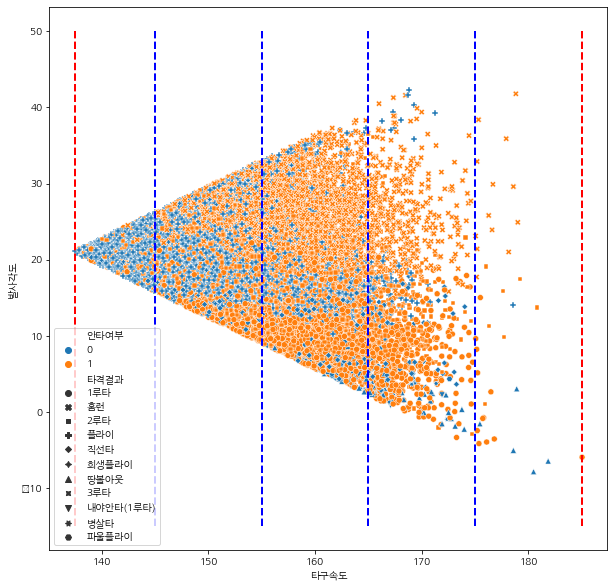

In [25]:
plt.subplots(figsize=(10, 10))
sns.scatterplot(x="타구속도", y="발사각도", hue = '안타여부', style = '타격결과', data=barrel1)
plt.plot([barrel1['타구속도'].min(), barrel1['타구속도'].min()], [-15, 50], "--r", linewidth=2) #min

plt.plot([a, a], [-15, 50], "--b", linewidth=2) # 9.312
plt.plot([b, b], [-15, 50], "--b", linewidth=2)
plt.plot([c, c], [-15, 50], "--b", linewidth=2)
plt.plot([d, d], [-15, 50], "--b", linewidth=2)

plt.plot([barrel1['타구속도'].max(), barrel1['타구속도'].max()], [-15, 50], "--r", linewidth=2) #max
# plt.plot([134.25, 180.81], [19.811539461708612, 19.811539461708612], "--b", linewidth=2)

plt.legend()
plt.show()

In [26]:
barrel_1 = barrel1[(barrel1['타구속도']>=barrel1['타구속도'].min()) &(barrel1['타구속도']<a)]
barrel_2 = barrel1[(barrel1['타구속도']>=a) &(barrel1['타구속도']<b)]
barrel_3 = barrel1[(barrel1['타구속도']>=b) &(barrel1['타구속도']<c)]
barrel_4 = barrel1[(barrel1['타구속도']>=c) &(barrel1['타구속도']<d)]
barrel_5 = barrel1[(barrel1['타구속도']>=d) &(barrel1['타구속도']<barrel1['타구속도'].max())]

In [27]:
print(barrel_1['타구속도'].min(), '~', barrel_1['타구속도'].max(),'/',barrel_1['발사각도'].min(), '~', barrel_1['발사각도'].max())
print(barrel_2['타구속도'].min(), '~', barrel_2['타구속도'].max(),'/',barrel_2['발사각도'].min(), '~', barrel_2['발사각도'].max())
print(barrel_3['타구속도'].min(), '~', barrel_3['타구속도'].max(),'/',barrel_3['발사각도'].min(), '~', barrel_3['발사각도'].max())
print(barrel_4['타구속도'].min(), '~', barrel_4['타구속도'].max(),'/',barrel_4['발사각도'].min(), '~', barrel_4['발사각도'].max())
print(barrel_5['타구속도'].min(), '~', barrel_5['타구속도'].max(),'/',barrel_5['발사각도'].min(), '~', barrel_5['발사각도'].max())

137.49 ~ 144.99 / 15.9 ~ 25.8
145.0 ~ 154.99 / 9.3 ~ 32.7
155.0 ~ 164.99 / 2.6 ~ 38.3
165.0 ~ 174.79 / -3.4 ~ 42.3
175.07 ~ 181.87 / -7.9 ~ 41.8


In [28]:
hts_pasaeng

,연도,경기코드,타구코드,선수코드,타자 팀 코드,이닝,타구속도,발사각도,타격결과,투구구속,해당구장,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
0,2018,20180324HHWO0,180324_140436,62797,HH,1,131.50,42.7,플라이,149.59,고척,0,0,78.322842,0.488539,0.695866,209.822842,1.184405,0
1,2018,20180324HHWO0,180324_140514,76753,HH,1,135.18,9.9,1루타,148.78,고척,1,1,88.877158,0.523687,0.844101,224.057158,1.367788,0
2,2018,20180324HHWO0,180324_140647,71752,HH,1,152.41,2.1,1루타,148.59,고척,1,1,81.077158,0.688252,0.734551,233.487158,1.422803,0
3,2018,20180324HHWO0,180324_140911,62700,HH,1,113.72,13.5,1루타,139.13,고척,1,1,92.477158,0.318720,0.894663,206.197158,1.213383,0
4,2018,20180324HHWO0,180324_142310,78288,HH,2,161.90,3.5,1루타,145.75,고척,1,1,82.477158,0.778892,0.754213,244.377158,1.533106,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117682,2021,20210711LTSS0,210711_195321,50458,SS,8,141.23,-4.9,땅볼아웃,137.76,대구,0,0,74.077158,0.581471,0.636236,215.307158,1.217707,0
117683,2021,20210711LTSS0,210711_195424,62415,SS,8,101.09,31.8,1루타,138.51,대구,1,1,89.222842,0.198090,0.848956,190.312842,1.047046,0
117684,2021,20210711LTSS0,210711_195627,75566,SS,8,146.84,33.4,홈런,134.10,대구,1,4,87.622842,0.635053,0.826484,234.462842,1.461537,0
117685,2021,20210711LTSS0,210711_200047,69418,SS,8,146.12,23.9,홈런,139.96,대구,1,4,97.122842,0.628176,0.959911,243.242842,1.588087,1


In [29]:
hts_pasaeng.to_csv('0909_배럴추가hts.csv', encoding = 'cp949', index = False)

In [30]:
player = pd.read_csv('선수.csv', encoding = 'CP949')

In [41]:
hitter = pd.read_csv('0910_타자 성적_11이상.csv', encoding = 'CP949')

In [32]:
def barrel_ws(df_hts, df_player,df_hitter,name,point):
    code = df_player[df_player['선수명'] == name]['선수코드'].unique()[0] #이름 입력 받아서 선수코드 int로 가져옴
    
    df_name = hts_pasaeng[hts_pasaeng['선수코드'] == code]
#     df_name = hts_pasaeng[(hts_pasaeng['표준화_파생변수'] > point)]
#     df_name = df_name[(df_name['발사각도'] > 15) & (df_name['발사각도'] < 35)]
    
    #타율(BA) 계산하기 위해 필요
    ba = df_name[df_name['타격결과'] == '1루타'].shape[0] + df_name[df_name['타격결과'] == '2루타'].shape[0] + df_name[df_name['타격결과'] == '3루타'].shape[0] +df_name[df_name['타격결과'] == '홈런'].shape[0]
    #장타율(SLG) 계산하기 위해 필요
    slg = df_name[df_name['타격결과'] == '1루타'].shape[0] + df_name[df_name['타격결과'] == '2루타'].shape[0] *2 + df_name[df_name['타격결과'] == '3루타'].shape[0] * 3 + df_name[df_name['타격결과'] == '홈런'].shape[0]*4
    
    print('----------', name,'----------')
#     print('타율 = ',ba , '/',df_name.shape[0], ' = ', ba / df_name.shape[0])
#     print('장타율 = ',slg , '/',df_name.shape[0], ' = ', slg / df_name.shape[0])
    print('배럴타구 = ',df_name['배럴여부'].sum() )
    print('배럴타구 / 타석 = ',df_name['배럴여부'].sum(), '/', df_hitter[df_hitter['선수코드'] == code]['타석'].sum(), 
                                                  '=',df_name['배럴여부'].sum() / df_hitter[df_hitter['선수코드'] == code]['타석'].sum())
    print()
    

In [33]:
name_list = ['양의지', '강백호', '최정', '이정후', '홍창기', '피렐라', '강민호', '박동원', '나성범', '박건우',
            '김재환', '페르난데스', '김현수', '양석환', '알테어', '정훈', '추신수', '구자욱', '안치홍', '한유섬']

for name in name_list:
    barrel_ws(hts, player, hitter, name, barrel_point)

---------- 양의지 ----------
배럴타구 =  295
배럴타구 / 타석 =  295 / 1792 = 0.16462053571428573

---------- 강백호 ----------
배럴타구 =  283
배럴타구 / 타석 =  283 / 1993 = 0.14199698946312092

---------- 최정 ----------
배럴타구 =  243
배럴타구 / 타석 =  243 / 1953 = 0.12442396313364056

---------- 이정후 ----------
배럴타구 =  209
배럴타구 / 타석 =  209 / 2123 = 0.09844559585492228

---------- 홍창기 ----------
배럴타구 =  105
배럴타구 / 타석 =  105 / 848 = 0.12382075471698113

---------- 피렐라 ----------
배럴타구 =  46
배럴타구 / 타석 =  46 / 361 = 0.12742382271468145

---------- 강민호 ----------
배럴타구 =  160
배럴타구 / 타석 =  160 / 1533 = 0.10437051532941943

---------- 박동원 ----------
배럴타구 =  135
배럴타구 / 타석 =  135 / 1122 = 0.12032085561497326

---------- 나성범 ----------
배럴타구 =  240
배럴타구 / 타석 =  240 / 1648 = 0.14563106796116504

---------- 박건우 ----------
배럴타구 =  283
배럴타구 / 타석 =  283 / 1863 = 0.15190552871712293

---------- 김재환 ----------
배럴타구 =  342
배럴타구 / 타석 =  342 / 2079 = 0.1645021645021645

---------- 페르난데스 ----------
배럴타구 =  178
배럴타구 / 타석 =  178 / 1632 = 0.109

In [42]:
hitter

,연도,선수코드,경기수,타석,타수,타율,안타,홈런,루타,장타율,...,볼넷,삼진,고의4구,사구,병살타,출루율,OPS,wOBA,wRC+,WAR+
0,2018,60100,70,169,152,0.243,37,3,63,0.414,...,12,36,0,4,5,0.313609,0.727609,79.1,-0.11,-0.47
1,2018,60184,6,10,10,0.200,2,0,3,0.300,...,0,3,0,0,0,0.200000,0.500000,12.5,-0.05,0.03
2,2018,60343,83,174,162,0.216,35,8,63,0.389,...,8,49,0,3,3,0.265896,0.654896,54.5,-0.15,-0.69
3,2018,60523,91,194,174,0.305,53,7,86,0.494,...,16,39,1,1,4,0.360825,0.854825,110.7,0.91,-0.31
4,2018,60558,128,374,342,0.254,87,12,144,0.421,...,24,92,0,4,7,0.309973,0.730973,76.5,-0.10,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,2021,79240,69,301,279,0.323,90,4,122,0.437,...,18,19,1,3,12,0.368771,0.805771,102.2,1.71,-0.12
922,2021,79365,73,261,219,0.265,58,16,117,0.534,...,32,69,0,6,5,0.372093,0.906093,138.8,2.85,1.57
923,2021,79402,70,278,237,0.211,50,1,61,0.257,...,30,26,0,3,7,0.307407,0.564407,NaN,0.00,0.00
924,2021,79456,62,135,124,0.274,34,0,38,0.306,...,7,11,1,1,5,0.313433,0.619433,55.9,-0.16,-1.18


In [43]:
hitter18 = hitter.loc[(hitter['연도'] == 2018)]
hitter19 = hitter.loc[(hitter['연도'] == 2019)]
hitter20 = hitter.loc[(hitter['연도'] == 2020)]
hitter21 = hitter.loc[(hitter['연도'] == 2021)]

In [44]:
hts18 = hts_pasaeng[hts_pasaeng['연도'] == 2018]
pcode = hitter18['선수코드'].unique()
barrel = []
for code in pcode:
    barrel.append(hts18[hts18['선수코드']== code ]['배럴여부'].sum())   
hitter18['배럴갯수'] = barrel


hts19 = hts_pasaeng[hts_pasaeng['연도'] == 2019]
pcode = hitter19['선수코드'].unique()
barrel = []
for code in pcode:
    barrel.append(hts19[hts19['선수코드']== code ]['배럴여부'].sum())   
hitter19['배럴갯수'] = barrel


hts20 = hts_pasaeng[hts_pasaeng['연도'] == 2020]
pcode = hitter20['선수코드'].unique()
barrel = []
for code in pcode:
    barrel.append(hts20[hts20['선수코드']== code ]['배럴여부'].sum())   
hitter20['배럴갯수'] = barrel


hts21 = hts_pasaeng[hts_pasaeng['연도'] == 2021]
pcode = hitter21['선수코드'].unique()
barrel = []
for code in pcode:
    barrel.append(hts21[hts21['선수코드']== code ]['배럴여부'].sum())   
hitter21['배럴갯수'] = barrel

In [45]:
hitter18

,연도,선수코드,경기수,타석,타수,타율,안타,홈런,루타,장타율,...,삼진,고의4구,사구,병살타,출루율,OPS,wOBA,wRC+,WAR+,배럴갯수
0,2018,60100,70,169,152,0.243,37,3,63,0.414,...,36,0,4,5,0.313609,0.727609,79.1,-0.11,-0.47,16
1,2018,60184,6,10,10,0.200,2,0,3,0.300,...,3,0,0,0,0.200000,0.500000,12.5,-0.05,0.03,1
2,2018,60343,83,174,162,0.216,35,8,63,0.389,...,49,0,3,3,0.265896,0.654896,54.5,-0.15,-0.69,13
3,2018,60523,91,194,174,0.305,53,7,86,0.494,...,39,1,1,4,0.360825,0.854825,110.7,0.91,-0.31,26
4,2018,60558,128,374,342,0.254,87,12,144,0.421,...,92,0,4,7,0.309973,0.730973,76.5,-0.10,-0.03,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,2018,79530,21,15,14,0.286,4,0,6,0.429,...,5,0,0,1,0.333333,0.762333,NaN,0.04,-0.05,2
223,2018,79608,130,549,494,0.342,169,23,278,0.563,...,57,1,10,13,0.391621,0.954621,140.3,4.98,4.06,79
224,2018,79705,58,102,85,0.259,22,4,39,0.459,...,26,0,3,3,0.363636,0.822636,98.8,0.34,0.25,9
225,2018,99606,88,205,183,0.295,54,4,77,0.421,...,49,1,5,5,0.365854,0.786854,102.7,0.70,-0.32,21


In [46]:
hitter = pd.concat([hitter18, hitter19, hitter20, hitter21])

In [47]:
hitter['배럴비율'] = hitter['배럴갯수']/hitter['타석']

In [48]:
hitter.to_csv('0910_final_hitter.csv', encoding = 'CP949')

In [49]:
hitter

,연도,선수코드,경기수,타석,타수,타율,안타,홈런,루타,장타율,...,고의4구,사구,병살타,출루율,OPS,wOBA,wRC+,WAR+,배럴갯수,배럴비율
0,2018,60100,70,169,152,0.243,37,3,63,0.414,...,0,4,5,0.313609,0.727609,79.1,-0.11,-0.47,16,0.094675
1,2018,60184,6,10,10,0.200,2,0,3,0.300,...,0,0,0,0.200000,0.500000,12.5,-0.05,0.03,1,0.100000
2,2018,60343,83,174,162,0.216,35,8,63,0.389,...,0,3,3,0.265896,0.654896,54.5,-0.15,-0.69,13,0.074713
3,2018,60523,91,194,174,0.305,53,7,86,0.494,...,1,1,4,0.360825,0.854825,110.7,0.91,-0.31,26,0.134021
4,2018,60558,128,374,342,0.254,87,12,144,0.421,...,0,4,7,0.309973,0.730973,76.5,-0.10,-0.03,32,0.085561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,2021,79240,69,301,279,0.323,90,4,122,0.437,...,1,3,12,0.368771,0.805771,102.2,1.71,-0.12,28,0.093023
922,2021,79365,73,261,219,0.265,58,16,117,0.534,...,0,6,5,0.372093,0.906093,138.8,2.85,1.57,30,0.114943
923,2021,79402,70,278,237,0.211,50,1,61,0.257,...,0,3,7,0.307407,0.564407,NaN,0.00,0.00,9,0.032374
924,2021,79456,62,135,124,0.274,34,0,38,0.306,...,1,1,5,0.313433,0.619433,55.9,-0.16,-1.18,6,0.044444
